<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/PipelineAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

Устанавливаем класс с алгоритмами генерации

In [2]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-t342dgrx
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-t342dgrx
  Resolved https://github.com/Karasiari/graphmcf.git to commit 44969b6315e0821cf50ac106fdaa5f91f8a870d5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=47516 sha256=f4f0b9b7351f3d8003615ea577eb4ce4439ddb9defa086db6e75a551fc964264
  Stored in directory: /tmp/pip-ephem-wheel-cache-cyy0y0la/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


Подключаем солвер MCF для проверки наших алгоритмов типа "friendly-adversarial"

In [3]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

Для чтения графов от Hu

In [4]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

Читаем маленькие (<100 вершин) графы cola

In [5]:
small_graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

high_clustered_graphs_for_test_names = ['2024_north', '2024_south', '2024_southwest']
high_clusteres_graphs_for_test = get_graphs(path_to_folder, high_clustered_graphs_for_test_names , True)

Пишем дополнительные функции для простого запуска алгоритма по выборкам параметров

In [6]:
import random
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator, MCFGeneratorMultiGraph, MCFGeneratorMultiEdges
from graphmcf.data import compute_laplacian_matrix

def gravity_results(graph, beta, dyn_k):

  graph_gravity = GraphMCF(graph['adj_matrix'])
  graph_size = graph_gravity.n
  median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
  gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=dyn_k)
  res = gen.generate(graph_gravity)

  demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
  sol = solve_throughput(graph_gravity.graph, demands_laplacian)
  gamma = sol.gamma

  return (beta, gamma)


def multigraph_results(graph, alpha):

  graph_multigraph = GraphMCF(graph['adj_matrix'])
  graph_size = graph_multigraph.n
  gen = MCFGeneratorMultiGraph(epsilon=0.025,
                               p_ER = 2/graph_size, distribution="normal", median_weight_for_initial=20, var_for_initial=1, multi_max=5,
                               num_edges=None,
                               initial_generation='deterministic', demands_sum=int(1.5*graph_size*20),)
  res = gen.generate(graph=graph_multigraph, alpha_target=alpha)

  demands_laplacian = compute_laplacian_matrix(graph_multigraph.demands_graph)
  sol = solve_throughput(graph_multigraph.graph, demands_laplacian)
  gamma = sol.gamma

  return (alpha, gamma, abs(alpha - res.alpha_history[-1]) < 0.025)

def old_results(graph, alpha):

  graph_oldgraph = GraphMCF(graph['adj_matrix'])
  graph_size = graph_oldgraph.n
  gen = MCFGeneratorMultiEdges(epsilon=0.025,
                               p_ER = 2/graph_size, distribution="normal", median_weight_for_initial=20, var_for_initial=1,
                               demands_median_denominator=8, demands_var_denominator=16,
                               num_edges=None,
                               update_type_old="replace_weight", update_type_new="replace_weight",)
  res = gen.generate(graph=graph_oldgraph, alpha_target=alpha)

  demands_laplacian = compute_laplacian_matrix(graph_oldgraph.demands_graph)
  sol = solve_throughput(graph_oldgraph.graph, demands_laplacian)
  gamma = sol.gamma

  return (alpha, gamma, abs(alpha - res.alpha_history[-1]) < 0.025)

Случайно равномерно наберем параметров для проверки алгоритмов

In [7]:
sample_size = 20
betas_sample = [random.uniform(0, 1) for _ in range(sample_size)]
alphas_sample = [random.uniform(0, 1) for _ in range(sample_size)]

Визуализация зависимостей решения MCF от параметров алгоритмов

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def print_section_header(text, width=50):
    """Печатает заголовок раздела"""
    print("\n" + "\033[1m" + text + "\033[0m")
    print("-" * len(text))

def print_centered_title(text, width=80):
    """Печатает центрированный заголовок с жирным шрифтом (если терминал поддерживает)"""
    centered_text = text.center(width)
    # Попытка использовать жирный шрифт (работает в большинстве терминалов)
    print("\033[1m" + "=" * width + "\033[0m")
    print("\033[1m" + centered_text + "\033[0m")
    print("\033[1m" + "=" * width + "\033[0m")

def analyze_sample(x, y, name, ax, color='red'):
    """
    Анализирует одну выборку и строит график
    """

    if len(x) < 2 or len(y) < 2:

        # Создаем пустой график с сообщением
        ax.text(0.5, 0.5, 'Сошедшихся меньше 2',
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=12, color='red')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'{name}\nПлохая сходимость', fontweight='bold')
        ax.grid(True, alpha=0.3)
        return None, None

    # Вычисляем корреляцию Пирсона
    corr_coef, p_value = pearsonr(x, y)

    # Определяем статистическую значимость
    significance = "значим" if p_value < 0.05 else "не значим"

    # Выводим сводку
    print(f"Выборка: {name[1]}")
    print(f"Значение коэффициента корреляции Пирсона: {corr_coef:.4f}")
    print(f"Статзначимость результата при критическом значении 0.05: {significance} (p-value = {p_value:.4f})")
    print("-" * 50)

    # Строим график
    ax.scatter(x, y, color=color, alpha=0.7, s=30)
    ax.set_xlim(0, 1)  # Только по X фиксируем масштаб от 0 до 1
    if name[1] == 'gravity':
      ax.set_xlabel('beta')
    else:
      ax.set_xlabel('alpha target')
    ax.set_ylabel('gamma')
    ax.set_title(f'{name[1]}\nКорреляция: {corr_coef:.3f}')
    ax.grid(True, alpha=0.3)

    return corr_coef, p_value

Посмотрим результаты на маленьких графах cola


Прогоним и сравним алгоритмы в смысле связи с gamma на небольших и слабо кластеризованных графах cola


-------------------------------------------------------------------------------------------------------
                      Анализ для графа cola_t10                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.5583
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0105)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.7107
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0004)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5456
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0128)
--------------------------------------------------


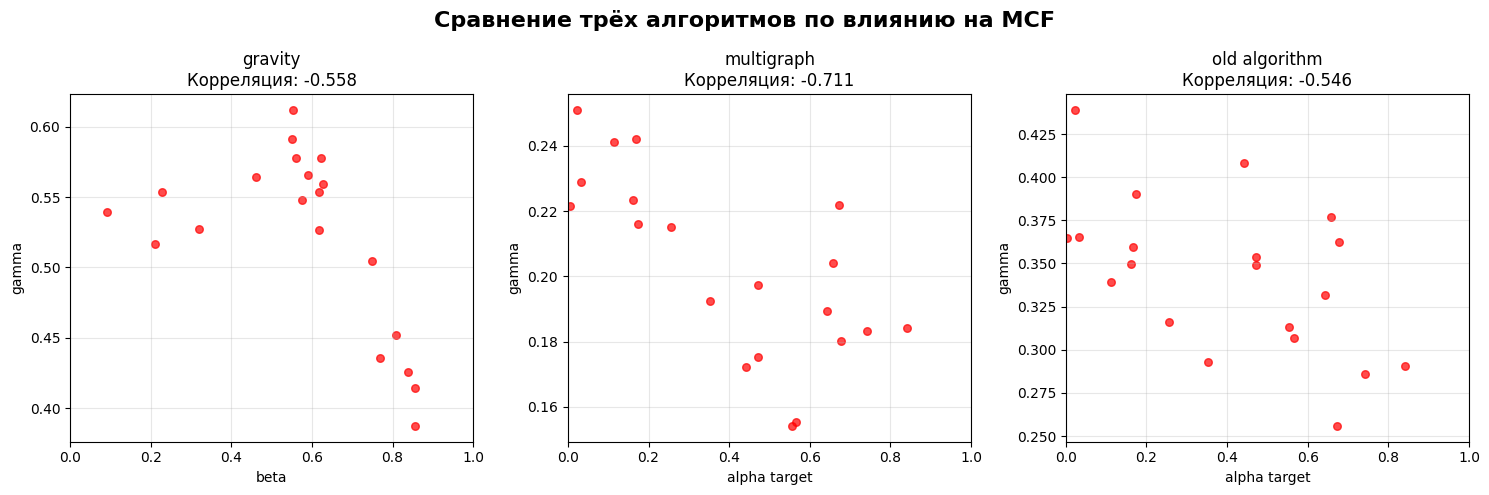

                       Анализ для графа cola_t3                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8839
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9087
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7240
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0003)
--------------------------------------------------


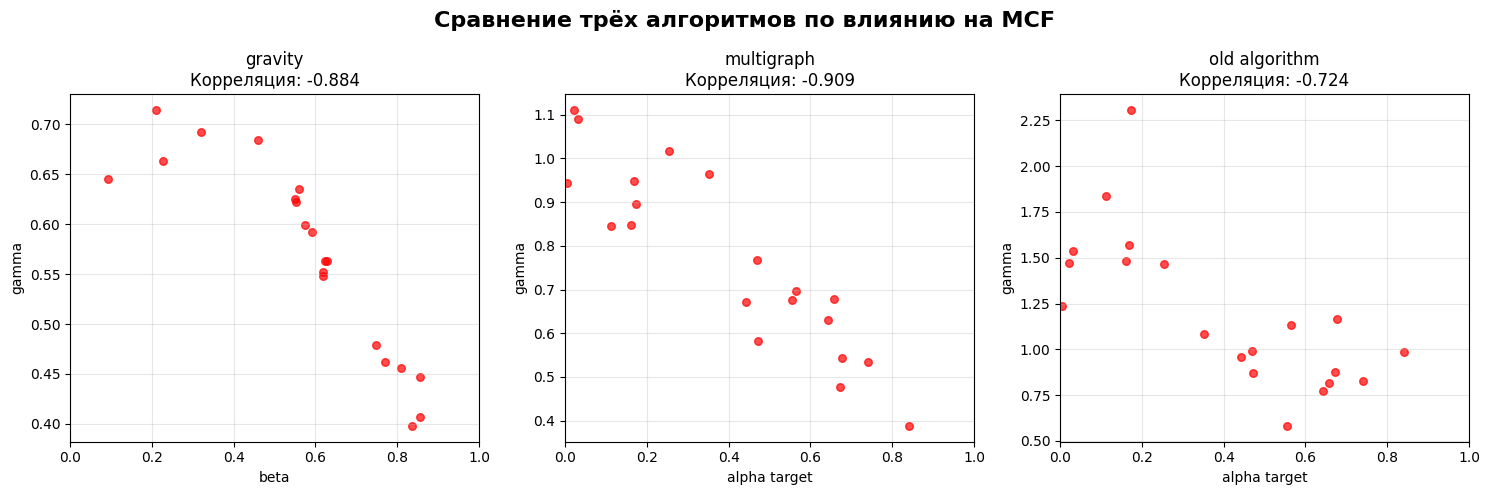

                       Анализ для графа cola_t8                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9522
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8262
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.4564
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0431)
--------------------------------------------------


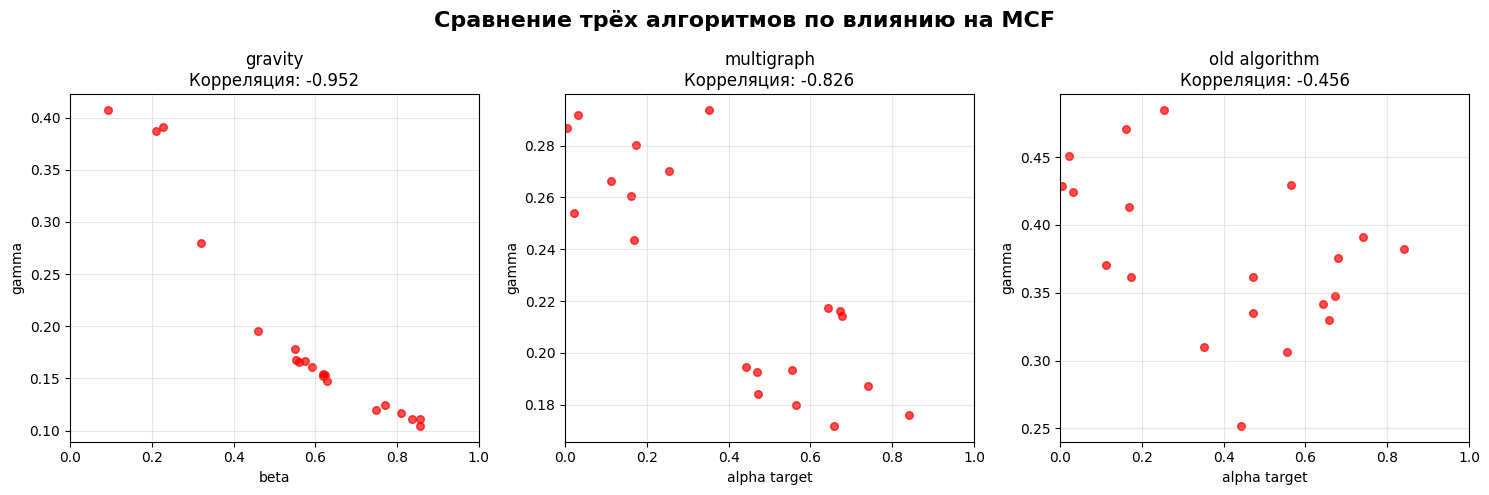

                       Анализ для графа cola_t2                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9702
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9582
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.8105
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


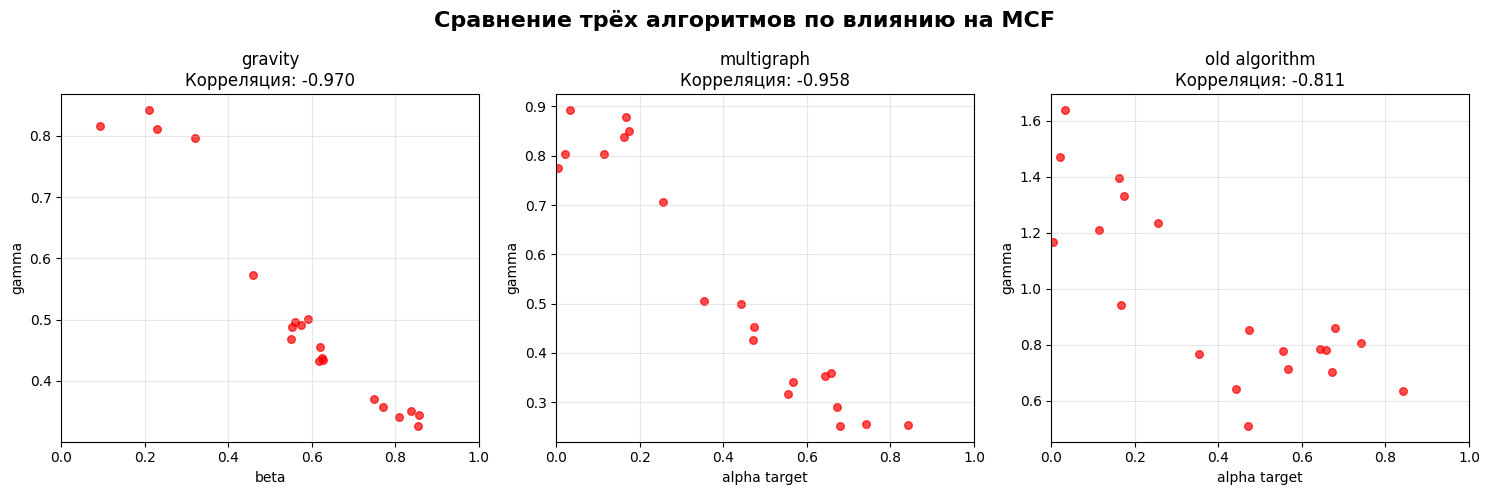

In [9]:
print_section_header("Прогоним и сравним алгоритмы в смысле связи с gamma на небольших и слабо кластеризованных графах cola\n\n")
output_for_gravity = {}
output_for_multigraph = {}
output_for_old = {}
for name, graph in small_graphs_for_test.items():
  output_for_gravity[name] = []
  output_for_multigraph[name] = []
  output_for_old[name] = []
  for beta in betas_sample:
    output = gravity_results(graph, beta, dyn_k=0.8)
    output_for_gravity[name].append(output)
  for alpha in alphas_sample:
    output = multigraph_results(graph, alpha)
    output_for_multigraph[name].append(output)
    output = old_results(graph, alpha)
    output_for_old[name].append(output)

  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1]], [j for (i, j, flag) in sample[1]], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

А теперь для multigraph и old_algorithm оставим только те результаты, которые сошлись к alpha_target


То же, но для сошедшихся multigraph и old algorithm


-----------------------------------------------------
                      Анализ для графа cola_t10                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.5583
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0105)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8644
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.1356)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.8835
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.3103)
--------------------------------------------------


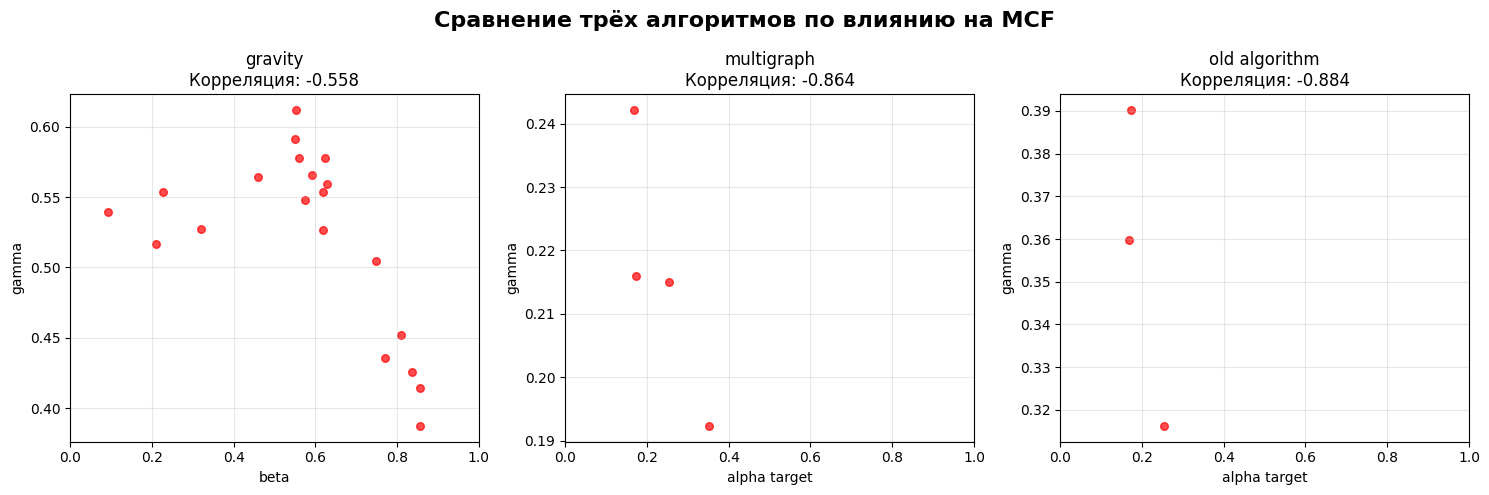

                       Анализ для графа cola_t3                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8839
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8936
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7498
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0200)
--------------------------------------------------


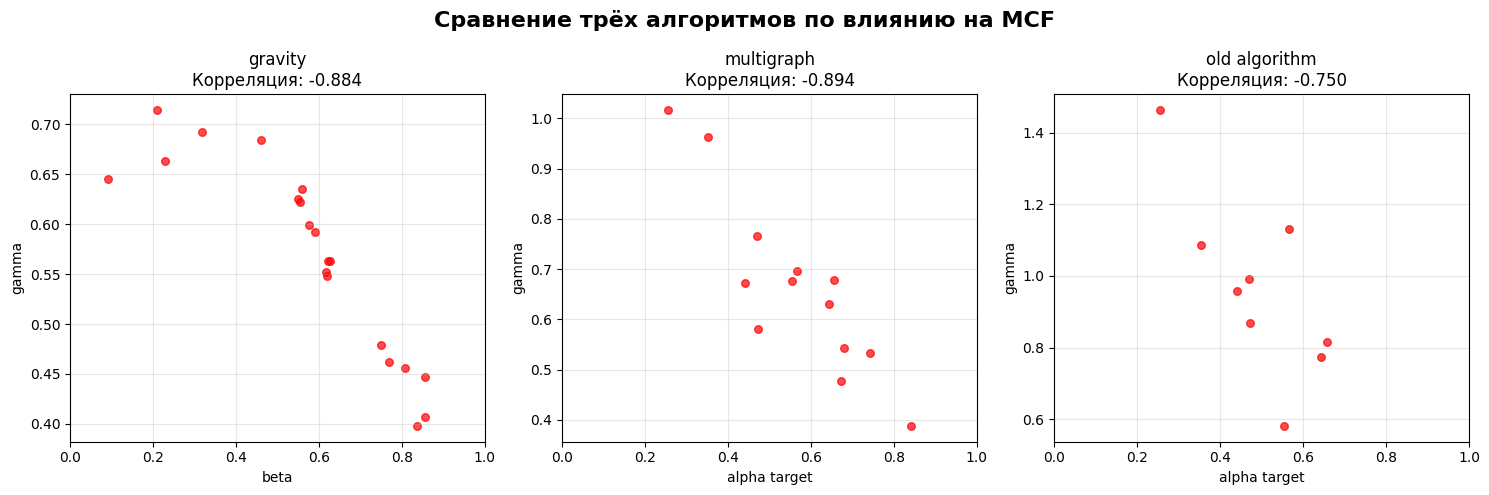

                       Анализ для графа cola_t8                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9522
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9985
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0349)
--------------------------------------------------


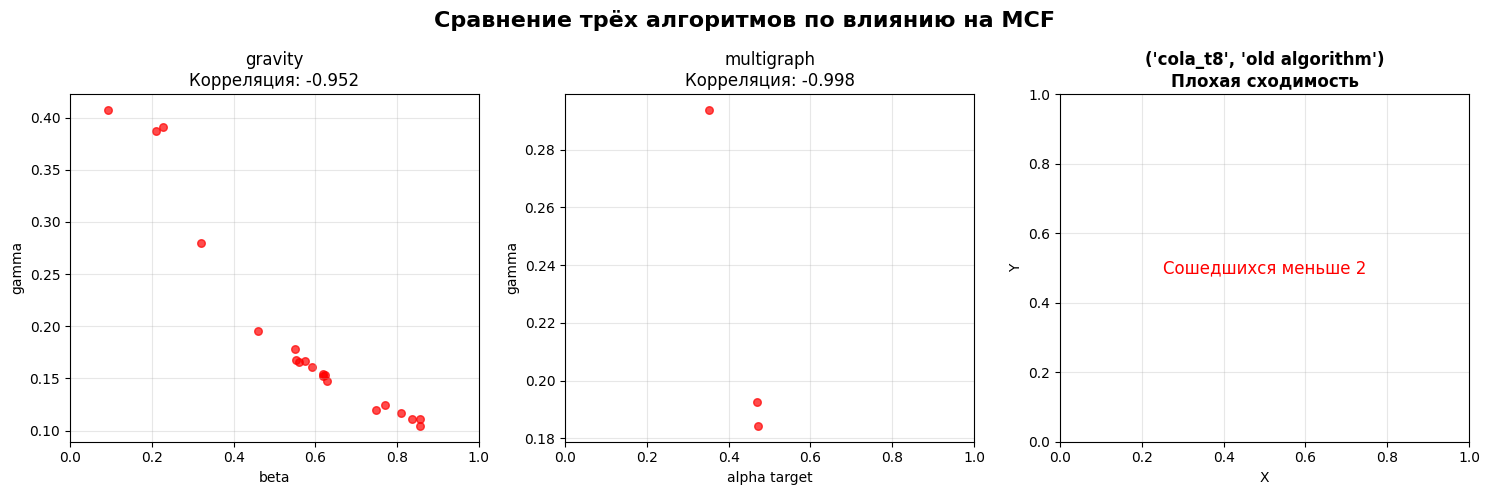

                       Анализ для графа cola_t2                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9702
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9694
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.8379
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0094)
--------------------------------------------------


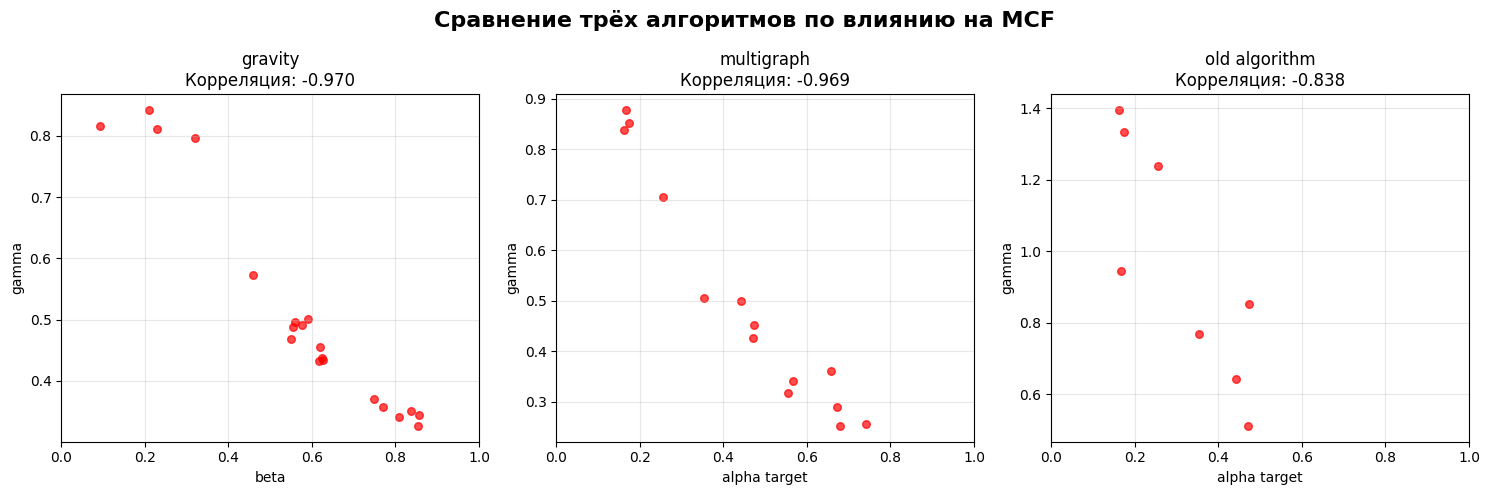

In [10]:
print_section_header("То же, но для сошедшихся multigraph и old algorithm\n\n")
for name, graph in small_graphs_for_test.items():
  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1] if flag], [j for (i, j, flag) in sample[1] if flag], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

Теперь проверим алгоритмы на маленьких графах со средней кластеризацией 2024


Прогоним и сравним алгоритмы в смысле связи с gamma на средне кластеризованных графах 2024


--------------------------------------------------------------------------------------------
                   Анализ для графа 2024_southwest                    

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.4062
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0756)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9203
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.2093
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.3758)
--------------------------------------------------


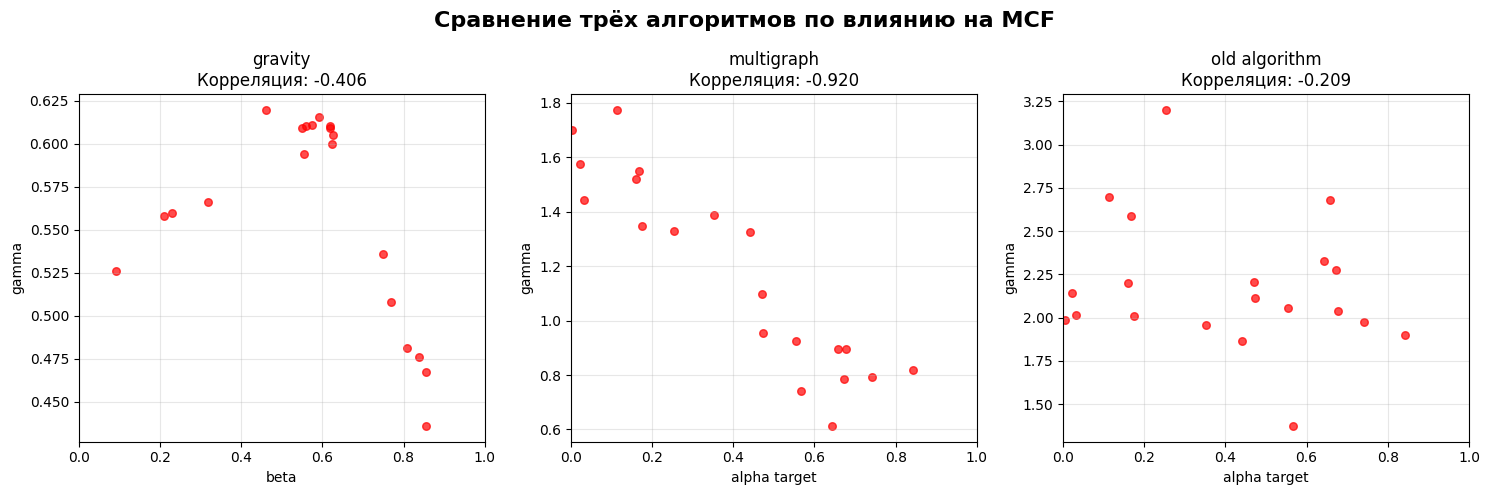

                     Анализ для графа 2024_south                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9542
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.6911
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0007)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.0433
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.8562)
--------------------------------------------------


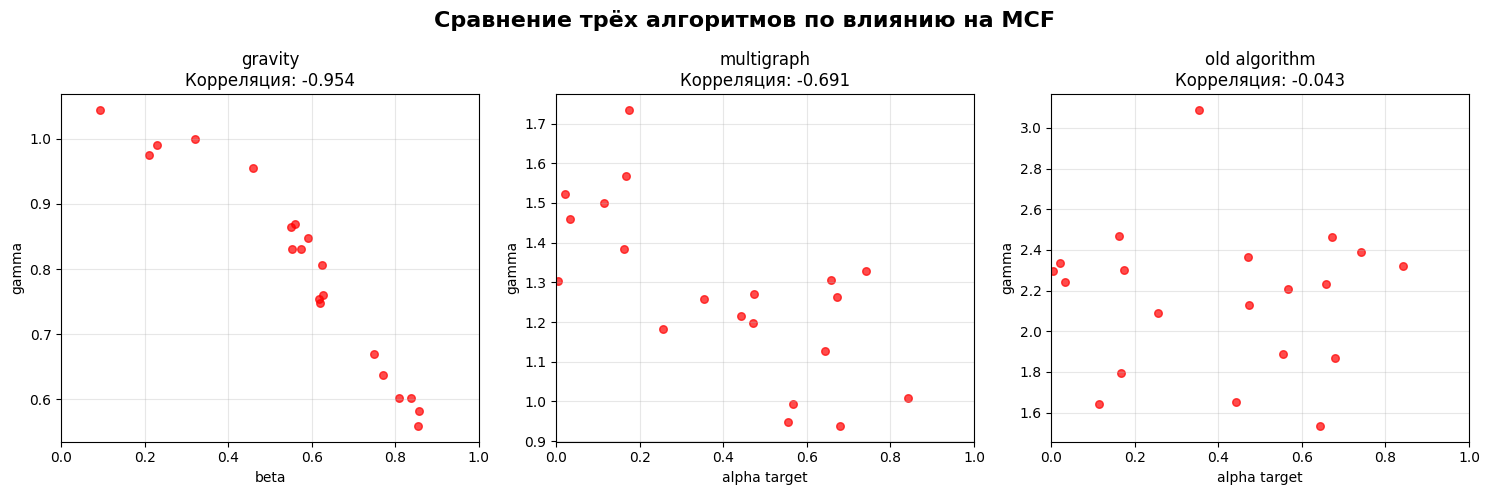

                     Анализ для графа 2024_north                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8124
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8170
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7140
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0004)
--------------------------------------------------


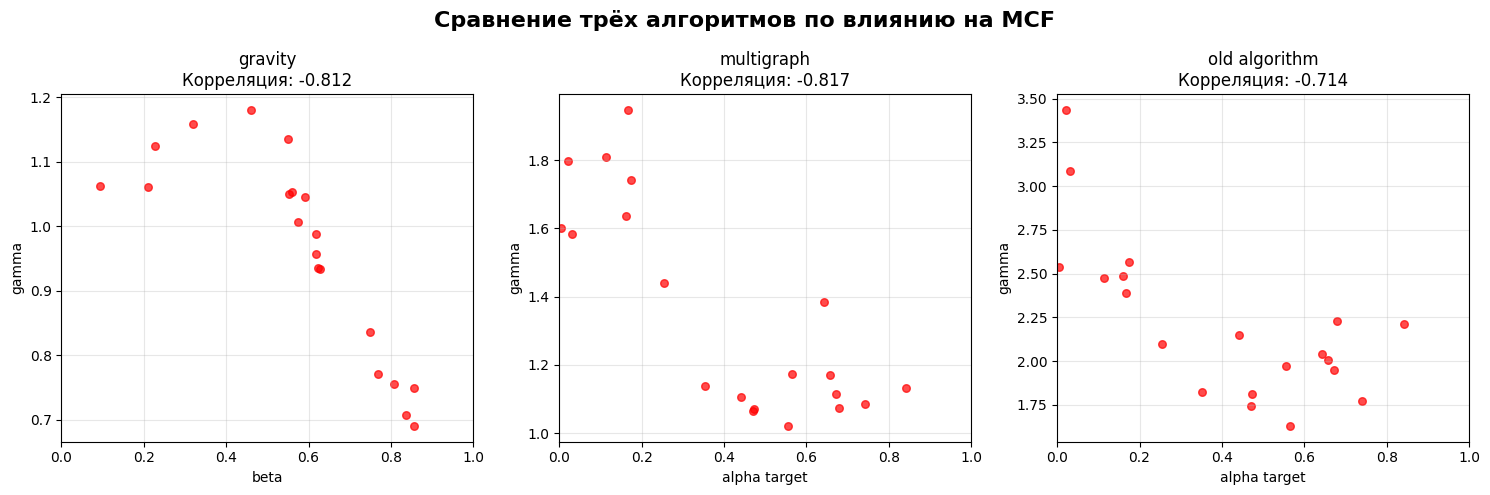

In [11]:
print_section_header("Прогоним и сравним алгоритмы в смысле связи с gamma на средне кластеризованных графах 2024\n\n")
output_for_gravity = {}
output_for_multigraph = {}
output_for_old = {}
for name, graph in high_clusteres_graphs_for_test.items():
  output_for_gravity[name] = []
  output_for_multigraph[name] = []
  output_for_old[name] = []
  for beta in betas_sample:
    output = gravity_results(graph, beta, dyn_k=0.95)
    output_for_gravity[name].append(output)
  for alpha in alphas_sample:
    output = multigraph_results(graph, alpha)
    output_for_multigraph[name].append(output)
    output = old_results(graph, alpha)
    output_for_old[name].append(output)

  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1]], [j for (i, j, flag) in sample[1]], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

А теперь для multigraph и old_algorithm оставим только те результаты, которые сошлись к alpha_target


То же, но для сошедшихся multigraph и old algorithm


-----------------------------------------------------
                   Анализ для графа 2024_southwest                    

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.4062
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0756)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8952
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0027)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -1.0000
Статзначимость результата при критическом значении 0.05: не значим (p-value = 1.0000)
--------------------------------------------------


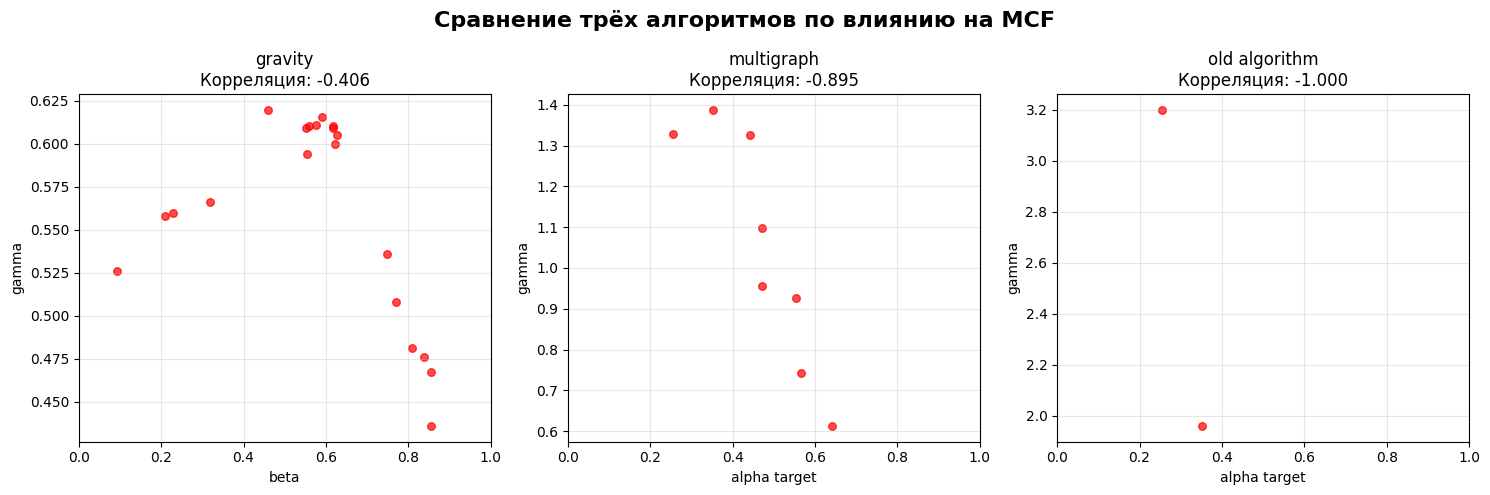

                     Анализ для графа 2024_south                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9542
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9335
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.2335)
--------------------------------------------------


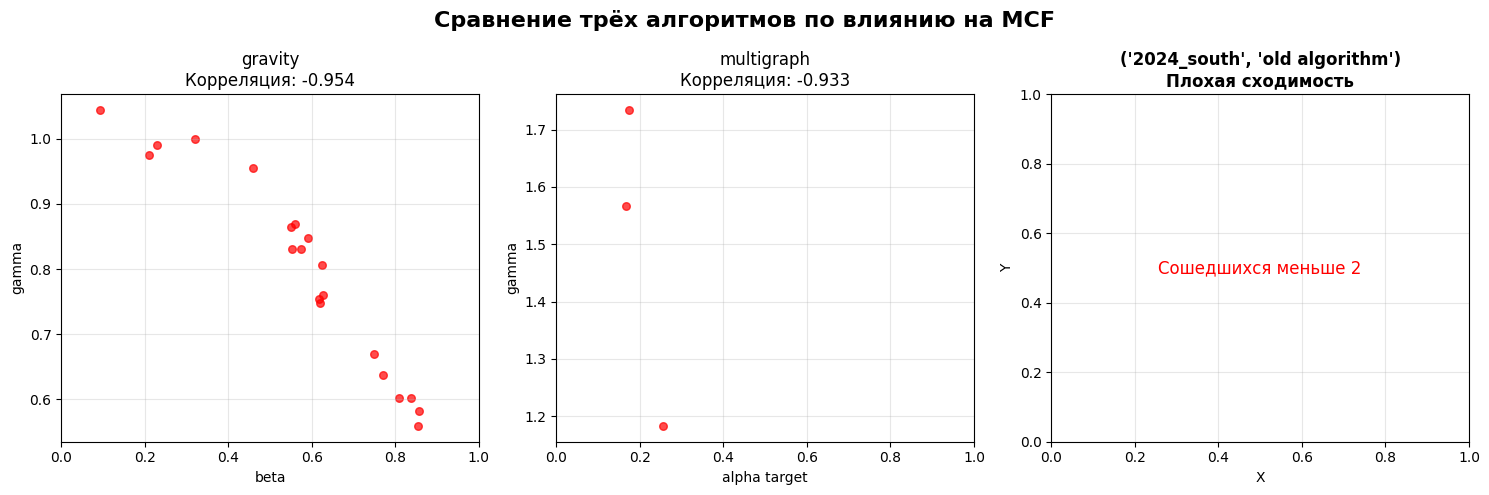

                     Анализ для графа 2024_north                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8124
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9723
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0277)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.9014
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.2851)
--------------------------------------------------


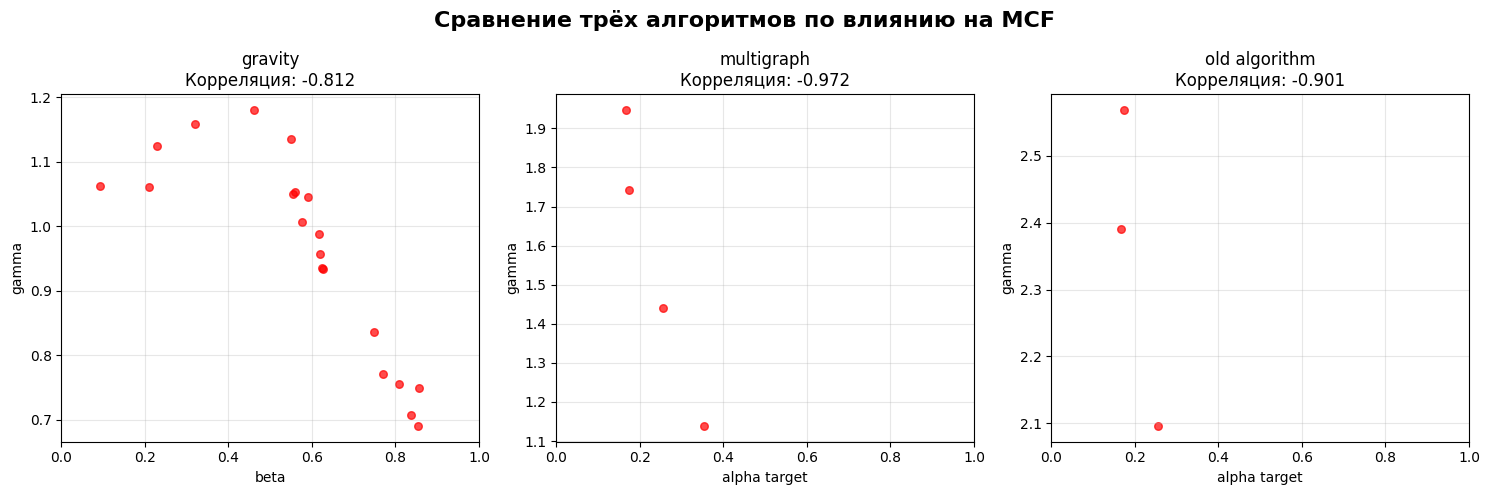

In [12]:
print_section_header("То же, но для сошедшихся multigraph и old algorithm\n\n")
for name, graph in high_clusteres_graphs_for_test.items():
  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1] if flag], [j for (i, j, flag) in sample[1] if flag], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

Теперь возьмем выборки параметров более "линейно"

In [13]:
sample_size = 20
betas_sample = np.arange(0.05, 1.00, 0.05)
alphas_sample = np.arange(0.05, 1.00, 0.05)

На cola графах


Прогоним и сравним алгоритмы в смысле связи с gamma на небольших и слабо кластеризованных графах cola


-------------------------------------------------------------------------------------------------------
                      Анализ для графа cola_t10                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.6550
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0023)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.7438
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0003)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.3824
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.1062)
--------------------------------------------------


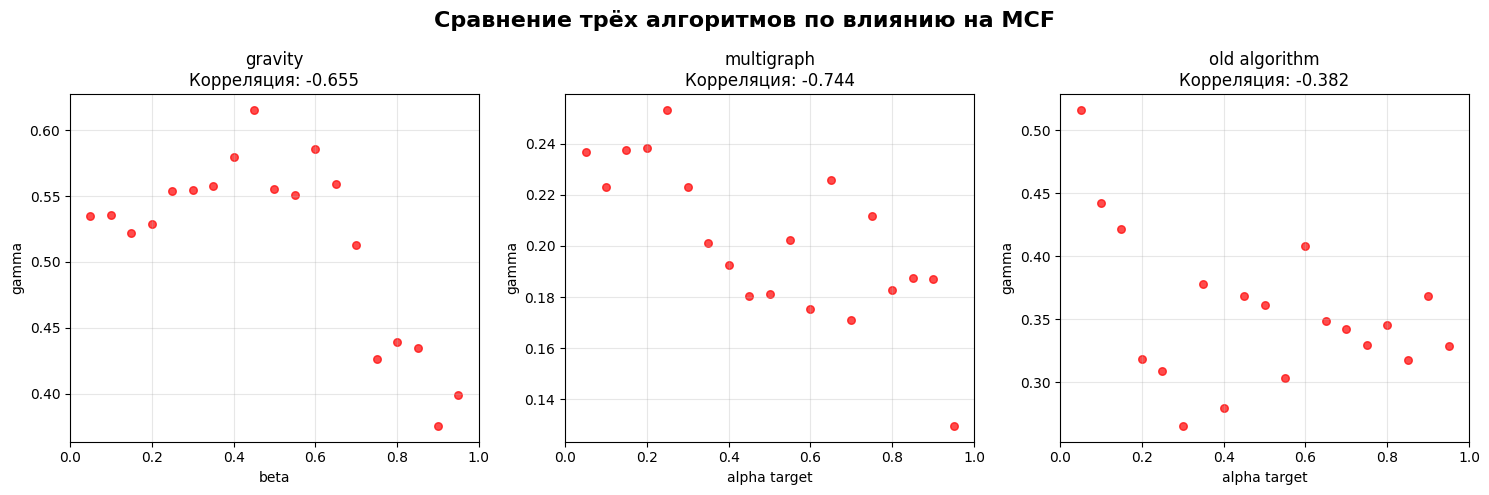

                       Анализ для графа cola_t3                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8054
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8508
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7579
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0002)
--------------------------------------------------


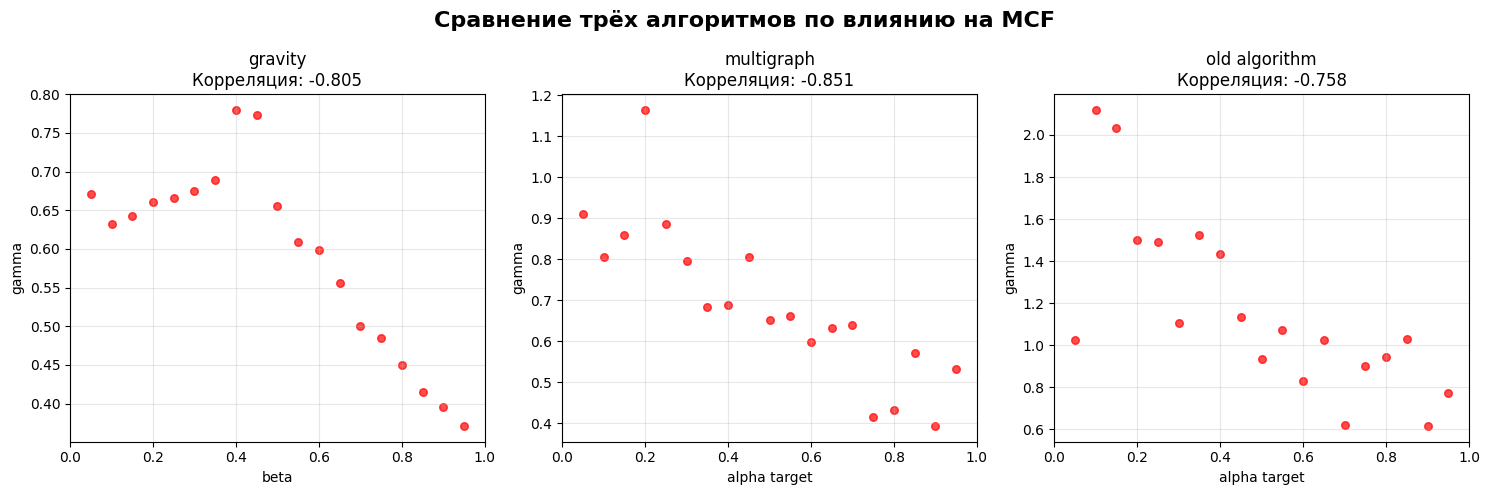

                       Анализ для графа cola_t8                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9583
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8179
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5095
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0259)
--------------------------------------------------


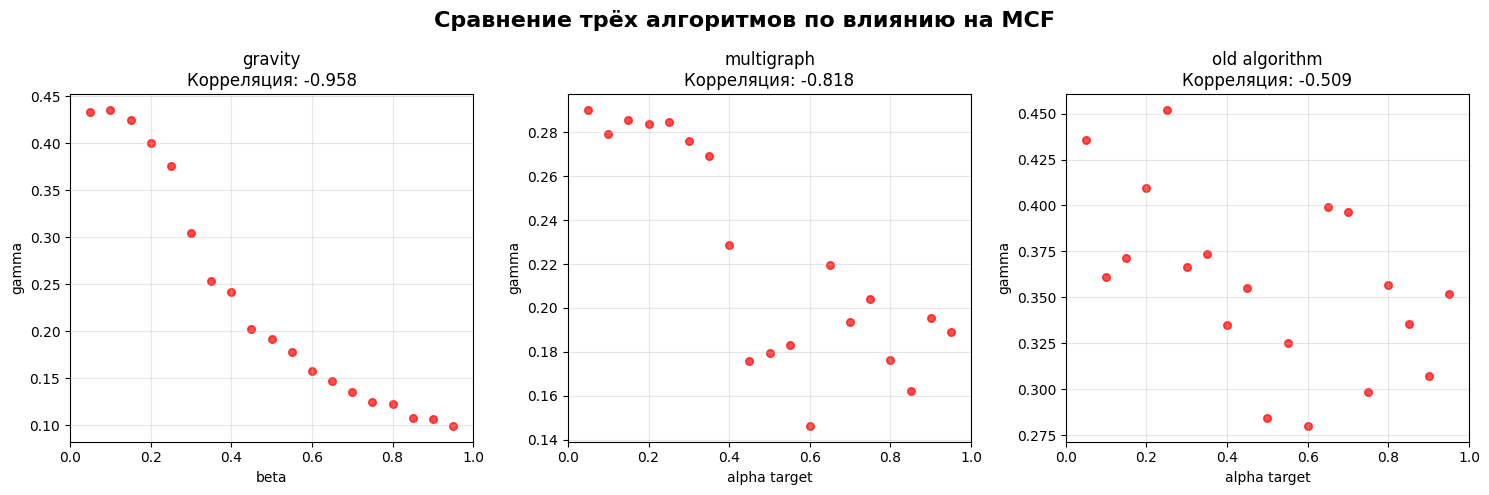

                       Анализ для графа cola_t2                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9673
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9269
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7331
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0004)
--------------------------------------------------


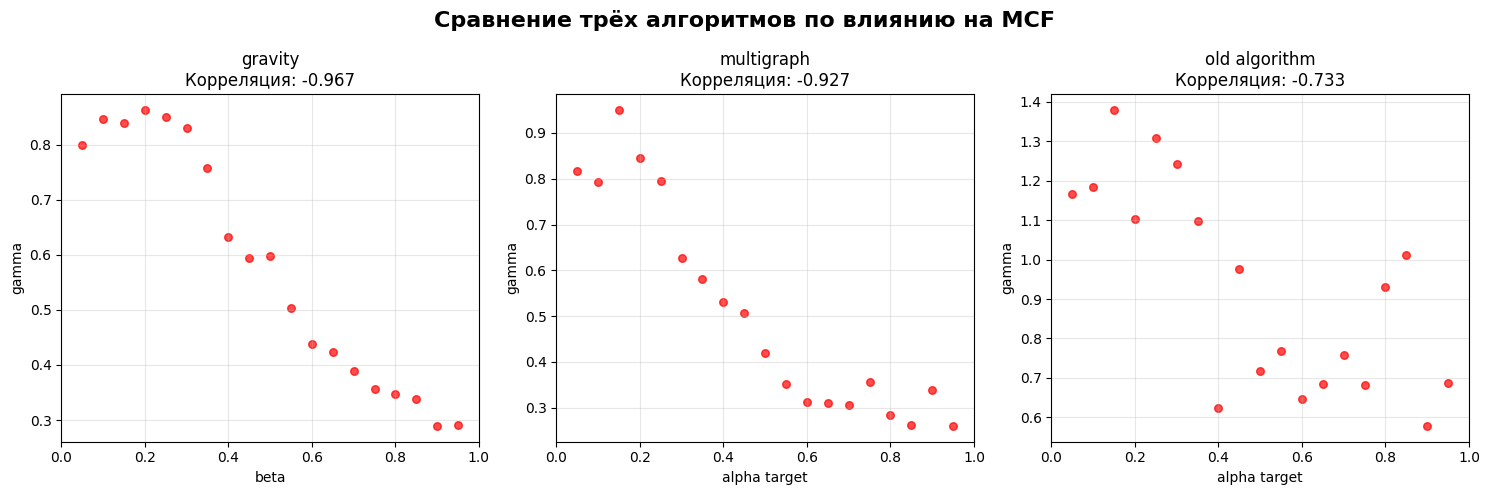

In [14]:
print_section_header("Прогоним и сравним алгоритмы в смысле связи с gamma на небольших и слабо кластеризованных графах cola\n\n")
output_for_gravity = {}
output_for_multigraph = {}
output_for_old = {}
for name, graph in small_graphs_for_test.items():
  output_for_gravity[name] = []
  output_for_multigraph[name] = []
  output_for_old[name] = []
  for beta in betas_sample:
    output = gravity_results(graph, beta, dyn_k=0.8)
    output_for_gravity[name].append(output)
  for alpha in alphas_sample:
    output = multigraph_results(graph, alpha)
    output_for_multigraph[name].append(output)
    output = old_results(graph, alpha)
    output_for_old[name].append(output)

  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1]], [j for (i, j, flag) in sample[1]], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

И только для сошедшихся


То же, но для сошедшихся multigraph и old algorithm


-----------------------------------------------------
                      Анализ для графа cola_t10                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.6550
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0023)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.5005
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.6663)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -1.0000
Статзначимость результата при критическом значении 0.05: не значим (p-value = 1.0000)
--------------------------------------------------


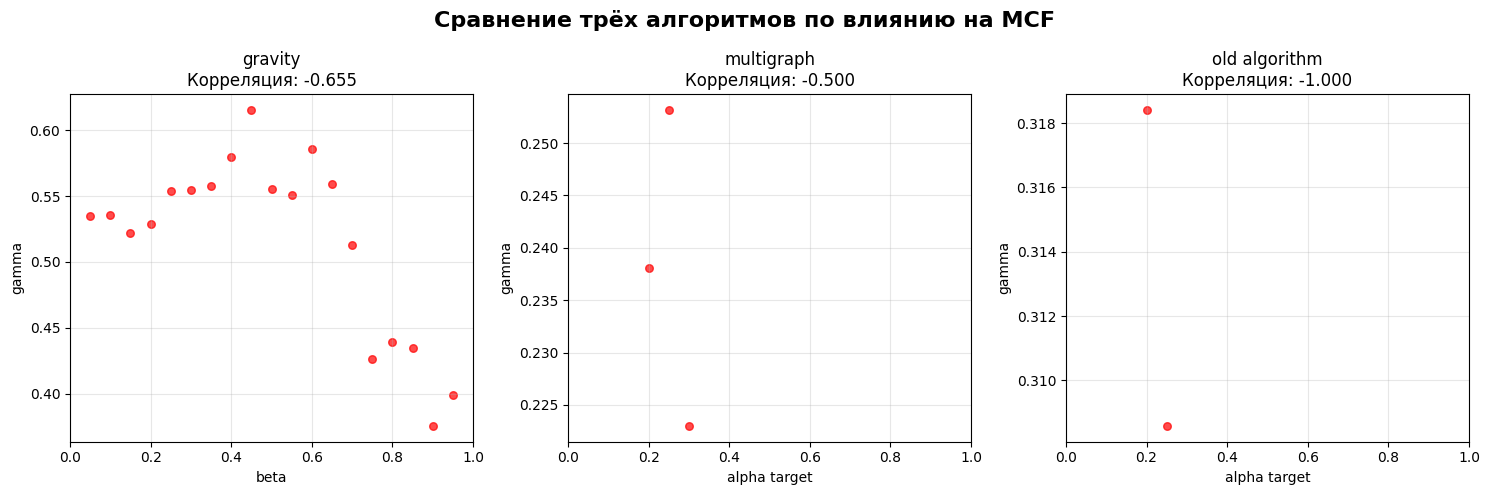

                       Анализ для графа cola_t3                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8054
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8702
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0001)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7641
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0101)
--------------------------------------------------


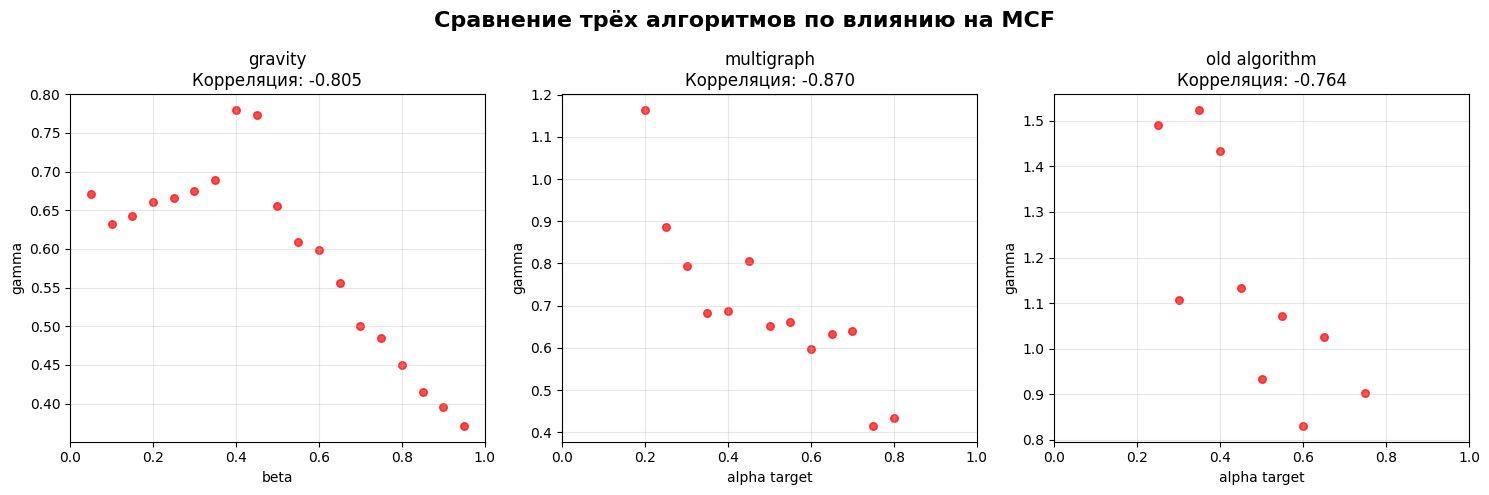

                       Анализ для графа cola_t8                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9583
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9516
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0127)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: 1.0000
Статзначимость результата при критическом значении 0.05: не значим (p-value = 1.0000)
--------------------------------------------------


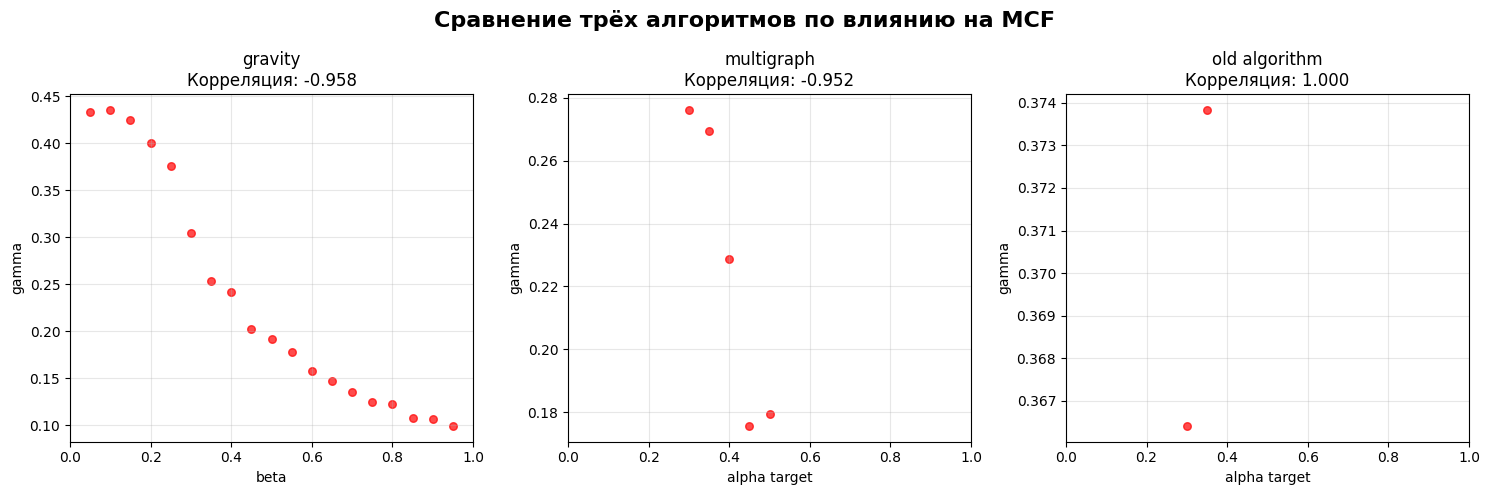

                       Анализ для графа cola_t2                       

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9673
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9712
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.8024
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0165)
--------------------------------------------------


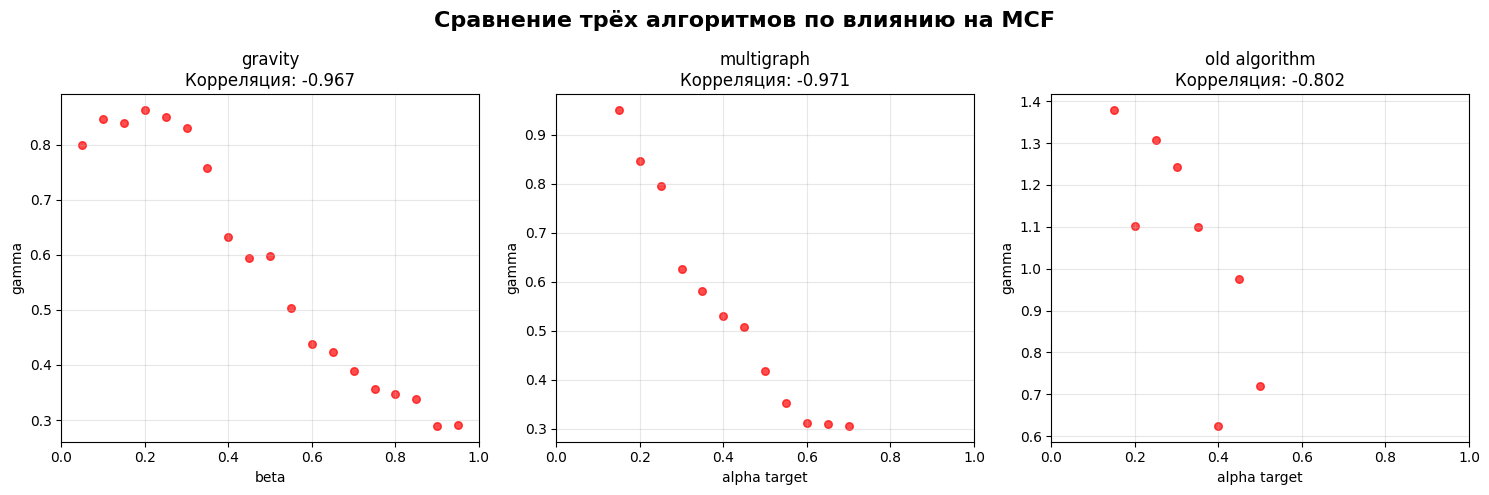

In [15]:
print_section_header("То же, но для сошедшихся multigraph и old algorithm\n\n")
for name, graph in small_graphs_for_test.items():
  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1] if flag], [j for (i, j, flag) in sample[1] if flag], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

На 2024 графах


Прогоним и сравним алгоритмы в смысле связи с gamma на средне кластеризованных графах 2024


--------------------------------------------------------------------------------------------
                   Анализ для графа 2024_southwest                    

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.4367
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0616)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8220
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.2891
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.2299)
--------------------------------------------------


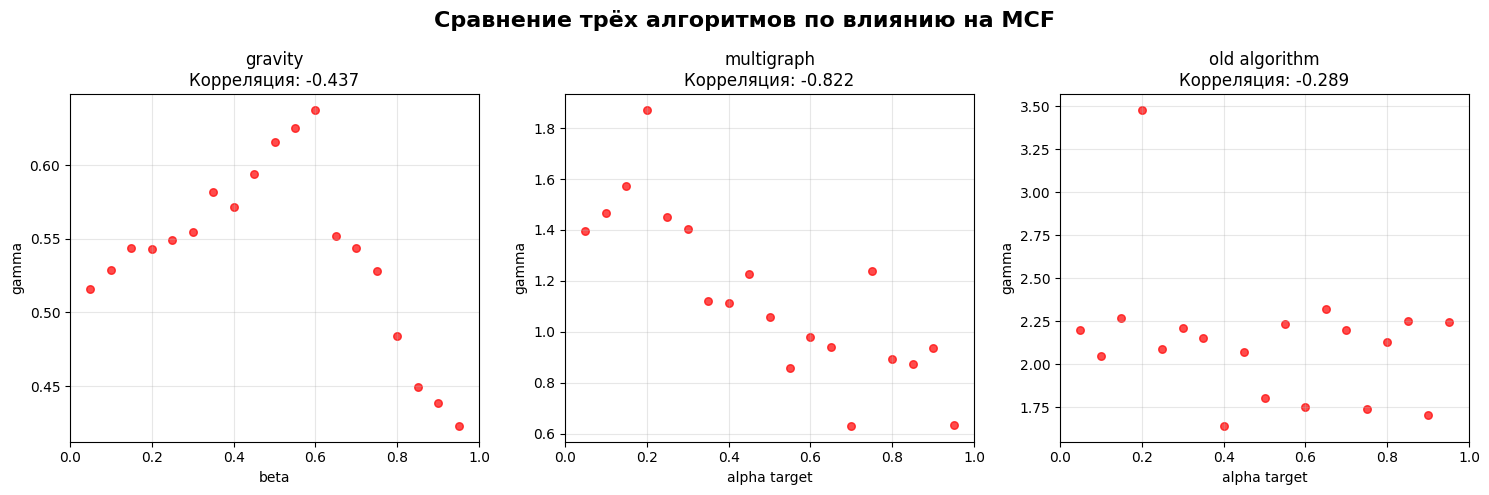

                     Анализ для графа 2024_south                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9296
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.6674
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0018)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5565
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0133)
--------------------------------------------------


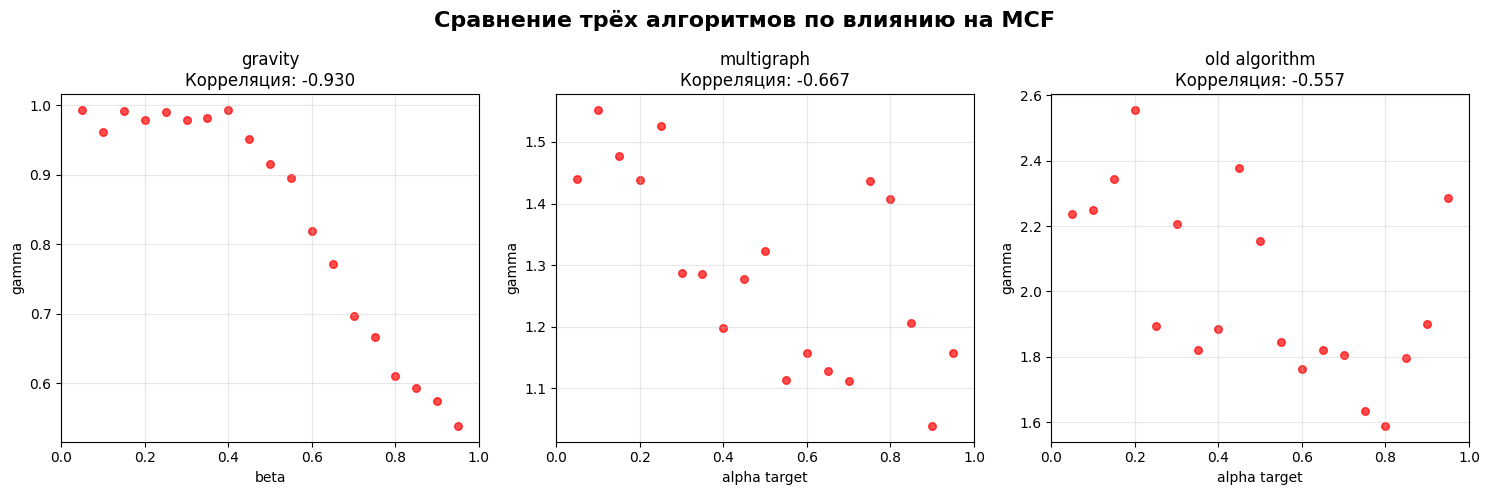

                     Анализ для графа 2024_north                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.7881
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0001)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9339
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6280
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0040)
--------------------------------------------------


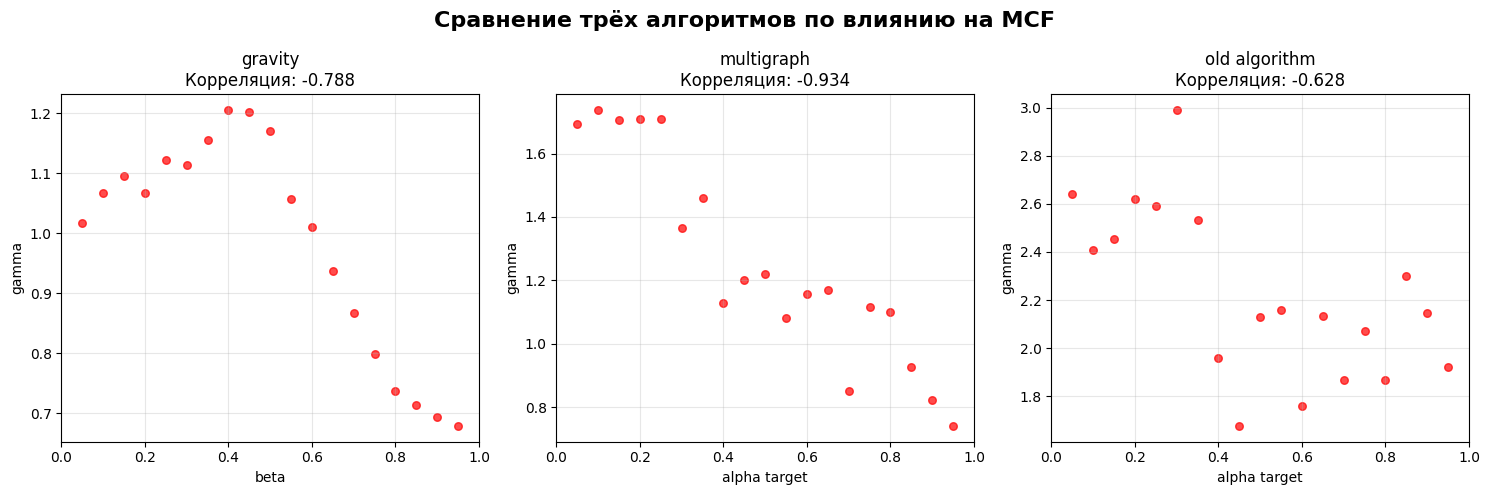

In [16]:
print_section_header("Прогоним и сравним алгоритмы в смысле связи с gamma на средне кластеризованных графах 2024\n\n")
output_for_gravity = {}
output_for_multigraph = {}
output_for_old = {}
for name, graph in high_clusteres_graphs_for_test.items():
  output_for_gravity[name] = []
  output_for_multigraph[name] = []
  output_for_old[name] = []
  for beta in betas_sample:
    output = gravity_results(graph, beta, dyn_k=0.95)
    output_for_gravity[name].append(output)
  for alpha in alphas_sample:
    output = multigraph_results(graph, alpha)
    output_for_multigraph[name].append(output)
    output = old_results(graph, alpha)
    output_for_old[name].append(output)

  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1]], [j for (i, j, flag) in sample[1]], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

Только для сошедшихся


То же, но для сошедшихся multigraph и old algorithm


-----------------------------------------------------
                   Анализ для графа 2024_southwest                    

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.4367
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0616)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9009
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0023)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.8287
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0829)
--------------------------------------------------


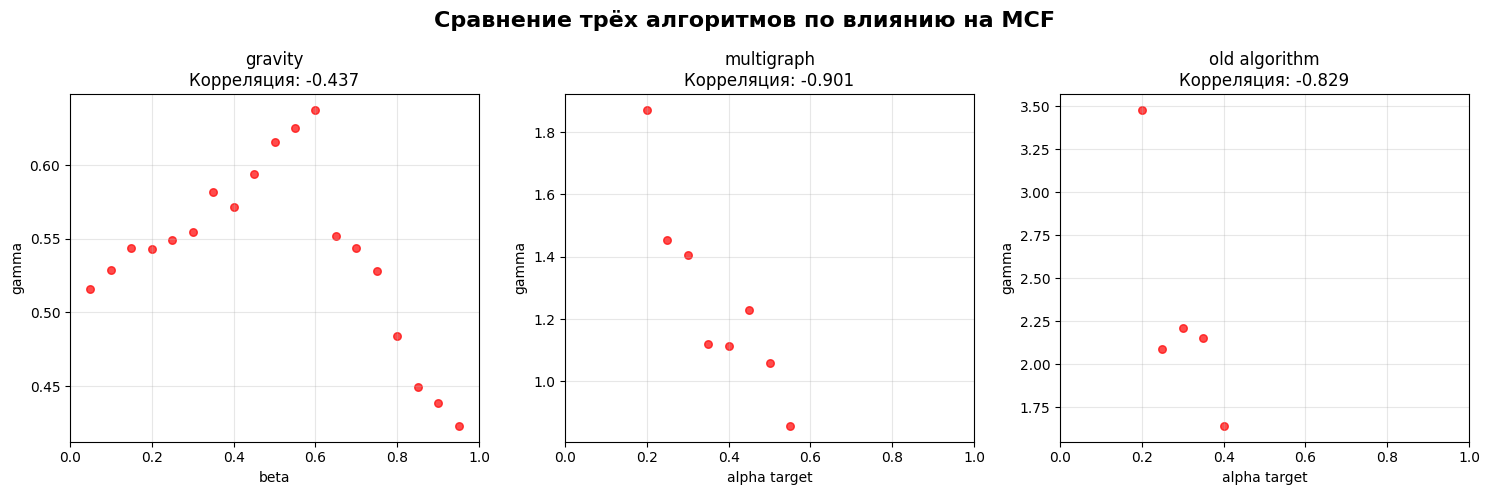

                     Анализ для графа 2024_south                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9296
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: 1.0000
Статзначимость результата при критическом значении 0.05: не значим (p-value = 1.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5004
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.4996)
--------------------------------------------------


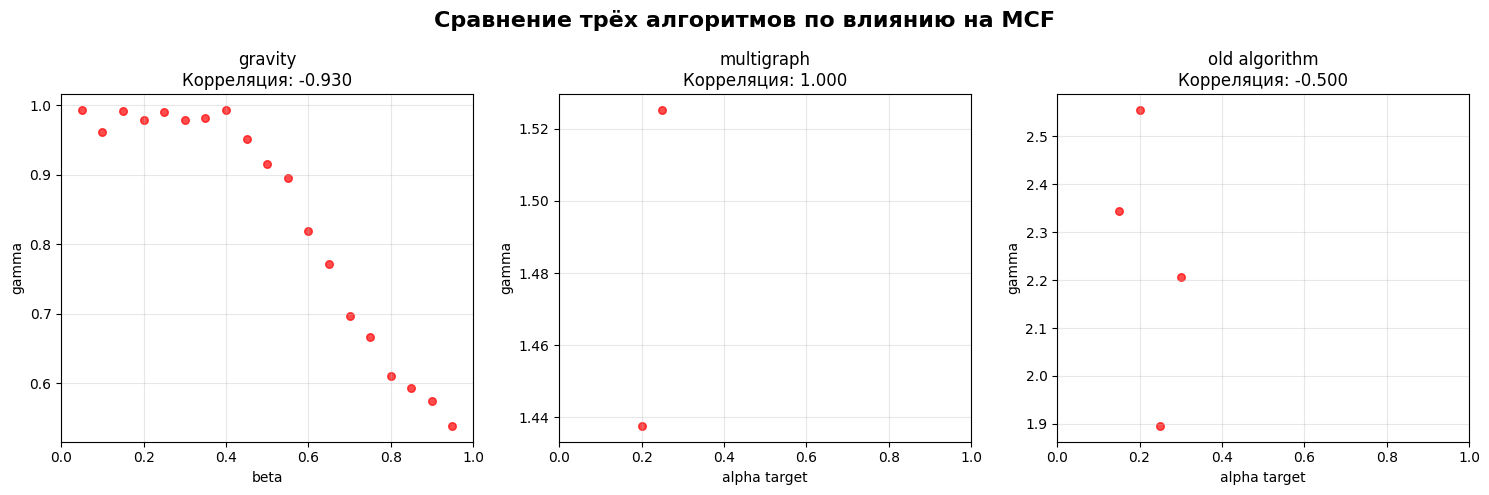

                     Анализ для графа 2024_north                      

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.7881
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0001)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8035
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.1965)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: 0.8308
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.3758)
--------------------------------------------------


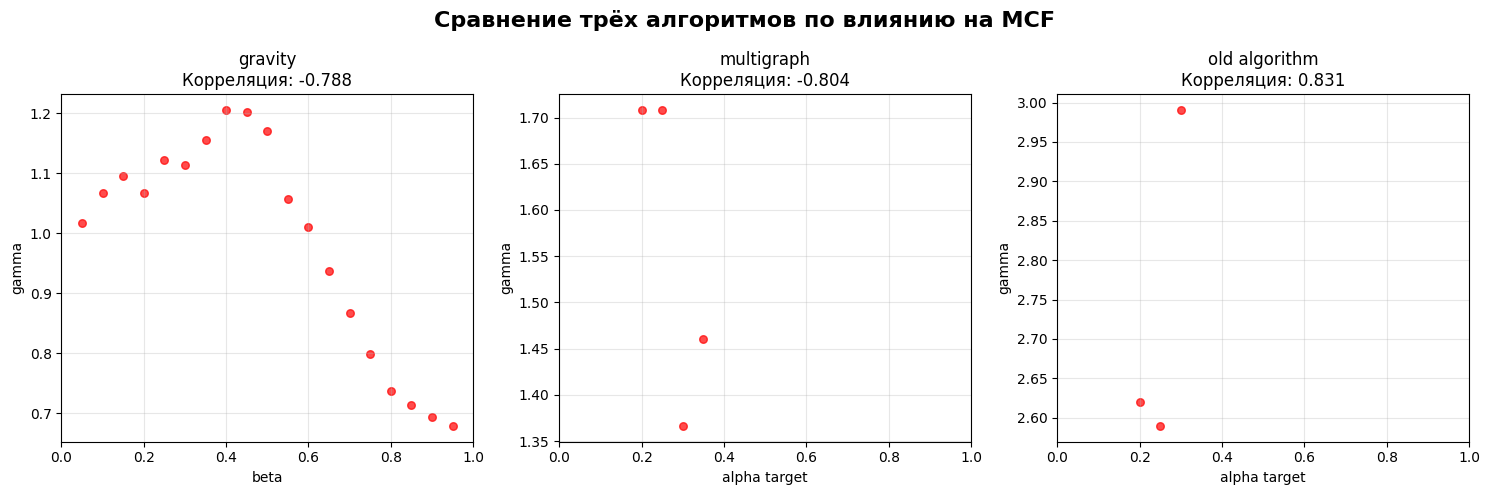

In [17]:
print_section_header("То же, но для сошедшихся multigraph и old algorithm\n\n")
for name, graph in high_clusteres_graphs_for_test.items():
  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1] if flag], [j for (i, j, flag) in sample[1] if flag], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()